## Logistic Regression Implementation on (scaled) Reduced Dataset with SVD

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data) and reduced dataset

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Read Train Data

In [4]:
X_train= pd.read_csv('../../DimensionalityReductionData/X_train_SVD.csv')
X_train.head()

,Dimension 1,Dimension 2
0,1.103460,0.072267
1,1.461354,-0.592586
2,1.647283,0.088656
3,1.676719,-0.541218
4,1.570116,-0.572993


Read Test Data

In [5]:
X_test = pd.read_csv('../../DimensionalityReductionData/X_test_SVD.csv')
X_test.head()

,Dimension 1,Dimension 2
0,1.220573,0.206269
1,1.250327,-0.570413
2,1.368459,-0.546002
3,1.277790,0.761160
4,1.636357,0.070829


Do Train-Test Split to define y_train, y_test (both are raings)
!!!! IMPORTANT use random_state as defined in Dimension Reduction DATA SPLIT!!!!

In [6]:
y_train, y_test = train_test_split(df_scaled['averageRating'], test_size=0.2, random_state=42)

Now everything is defined (X_train, X_test, y_train, y_test)

Save and print metrics

In [8]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

Model fit

In [9]:
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=23)

In [10]:
predictions = model.predict(X_test)

Metrics for LR-SVD-untuned:
Accuracy: 0.6079
Weighted F1: 0.6078
Weighted Precision: 0.6092
Weighted Recall: 0.6079
Macro-Averaged Precision: 0.6087
Macro-Averaged Recall: 0.6086
F1: [0.60383709 0.61193538]
Precision: [0.62639665 0.5910828 ]
classification report
              precision    recall  f1-score   support

     Class 0       0.63      0.58      0.60      1539
     Class 1       0.59      0.63      0.61      1463

    accuracy                           0.61      3002
   macro avg       0.61      0.61      0.61      3002
weighted avg       0.61      0.61      0.61      3002

Confusion Matrix


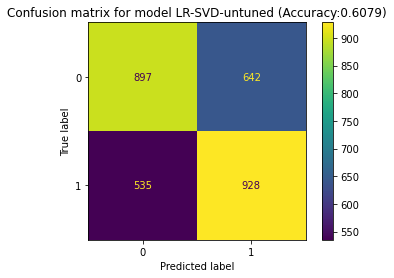

In [11]:
model_metrics = calculate_metrics('LR-SVD-untuned', y_test, predictions)

In [12]:
# Apar warning-uri ptc nu converge daca max_iter e mic (<100)
# Maximu pe care l-am pus e 10k si acolo nu apare niciun warning dar am lasat ca lista
# Ptc modelele cele mai bune sunt la la max_iter <500
warnings.filterwarnings(action='ignore')

## Grid Search with Cross-Validation

In [13]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 100, 200, 500, 100, 1000, 5000],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search_cv = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                               param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

Results of the best model 

In [15]:
accuracy_cv = best_model_cv.score(X_test, y_test)

print("Best Hyperparameters:", best_params_cv)
print("Accuracy:", accuracy_cv)

Best Hyperparameters: {'C': 1, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.6079280479680214


Results of best models Grid Search CV

In [16]:
df_cv = pd.DataFrame(grid_search_cv.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_cv = df_cv[['params', 'mean_test_score']]
df_results_cv_sorted = df_results_cv.sort_values(by='mean_test_score', ascending=False)

print(df_results_cv_sorted.head(5))

                                                params  mean_test_score
167  {'C': 100, 'max_iter': 5000, 'penalty': 'l2', ...         0.590837
155  {'C': 100, 'max_iter': 500, 'penalty': 'l2', '...         0.590837
87   {'C': 1, 'max_iter': 10, 'penalty': 'l2', 'sol...         0.590837
145  {'C': 100, 'max_iter': 100, 'penalty': 'l1', '...         0.590837
146  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...         0.590837


Metrics for LR-SVD_CV1_best:
Accuracy: 0.6079
Weighted F1: 0.6078
Weighted Precision: 0.6092
Weighted Recall: 0.6079
Macro-Averaged Precision: 0.6087
Macro-Averaged Recall: 0.6086
F1: [0.60383709 0.61193538]
Precision: [0.62639665 0.5910828 ]
classification report
              precision    recall  f1-score   support

     Class 0       0.63      0.58      0.60      1539
     Class 1       0.59      0.63      0.61      1463

    accuracy                           0.61      3002
   macro avg       0.61      0.61      0.61      3002
weighted avg       0.61      0.61      0.61      3002

Confusion Matrix


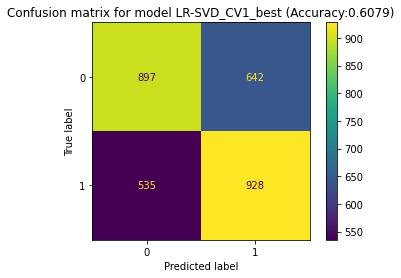

In [17]:
# Use best parameters to make predictions
predictions_cv = best_model_cv.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR-SVD_CV1_best', y_test, predictions_cv)])

## Grid Search Stratified K Fold Validation

In [18]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_skf = GridSearchCV(estimator=LogisticRegression(random_state=seed), 
                           param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search_skf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_skf = grid_search_skf.best_params_
best_model_skf = grid_search_skf.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters with Stratified K-Fold:", best_params_skf)
print("Accuracy with Stratified K-Fold:", accuracy)


Best Hyperparameters with Stratified K-Fold: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Accuracy with Stratified K-Fold: 0.6079280479680214


Results of the best model 

In [19]:
accuracy_skf = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters:", best_params_skf)
print("Accuracy:", accuracy_skf)

Best Hyperparameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.6079280479680214


Results of best models Grid Search CV

In [20]:
df_skf = pd.DataFrame(grid_search_skf.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_skf = df_skf[['params', 'mean_test_score']]
df_results_skf_sorted = df_results_skf.sort_values(by='mean_test_score', ascending=False)

print(df_results_skf_sorted.head(5))

                                                params  mean_test_score
103  {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'so...         0.590171
107  {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 's...         0.590171
136  {'C': 10, 'max_iter': 5000, 'penalty': 'l1', '...         0.590171
128  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...         0.590171
124  {'C': 10, 'max_iter': 500, 'penalty': 'l1', 's...         0.590171


Metrics for LR-SVD_skf_best:
Accuracy: 0.6079
Weighted F1: 0.6078
Weighted Precision: 0.6092
Weighted Recall: 0.6079
Macro-Averaged Precision: 0.6087
Macro-Averaged Recall: 0.6086
F1: [0.60383709 0.61193538]
Precision: [0.62639665 0.5910828 ]
classification report
              precision    recall  f1-score   support

     Class 0       0.63      0.58      0.60      1539
     Class 1       0.59      0.63      0.61      1463

    accuracy                           0.61      3002
   macro avg       0.61      0.61      0.61      3002
weighted avg       0.61      0.61      0.61      3002

Confusion Matrix


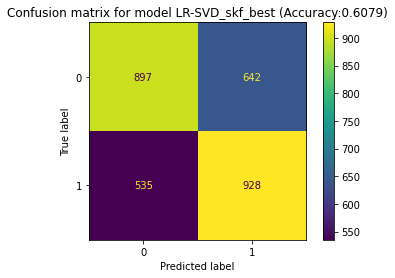

In [21]:
# Use best parameters to make predictions
predictions_skf = best_model_skf.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR-SVD_skf_best', y_test, predictions_skf)])

Next maybe add elastic search as penalty? only works with saga solver

# Tune with Optuna

In [22]:
def objective(trial):
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [23]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 20:00:28,215] A new study created in memory with name: no-name-2a0a9bc3-b13b-4629-bf8f-0efd5f63dfaa
[I 2024-06-09 20:00:28,254] Trial 0 finished with value: 0.6079280479680214 and parameters: {'penalty': 'l2', 'C': 1.978696921972353, 'max_iter': 354, 'solver': 'saga'}. Best is trial 0 with value: 0.6079280479680214.
[I 2024-06-09 20:00:28,295] Trial 1 finished with value: 0.6079280479680214 and parameters: {'penalty': 'l2', 'C': 0.7147547361025183, 'max_iter': 471, 'solver': 'saga'}. Best is trial 0 with value: 0.6079280479680214.
[I 2024-06-09 20:00:28,368] Trial 2 finished with value: 0.6062624916722186 and parameters: {'penalty': 'l1', 'C': 0.5871453092844537, 'max_iter': 981, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6079280479680214.
[I 2024-06-09 20:00:28,419] Trial 3 finished with value: 0.6079280479680214 and parameters: {'penalty': 'l1', 'C': 2.9335873033004263, 'max_iter': 664, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6079280479680214.
[

Best Hyperparameters: {'penalty': 'l2', 'C': 1.978696921972353, 'max_iter': 354, 'solver': 'saga'}
Best Accuracy: 0.6079280479680214


In [24]:
# Get best trials
trials_OTP1 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP1 = trials_OTP1.sort_values(by='value', ascending=False).head(10)
top_trials_OTP1

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_penalty,params_solver,state
0,0,0.607928,2024-06-09 20:00:28.217456,2024-06-09 20:00:28.254453,0 days 00:00:00.036997,1.978697,354,l2,saga,COMPLETE
121,121,0.607928,2024-06-09 20:00:32.215349,2024-06-09 20:00:32.243408,0 days 00:00:00.028059,3.338118,157,l2,saga,COMPLETE
132,132,0.607928,2024-06-09 20:00:32.485371,2024-06-09 20:00:32.495374,0 days 00:00:00.010003,1.186426,237,l2,liblinear,COMPLETE
135,135,0.607928,2024-06-09 20:00:32.529338,2024-06-09 20:00:32.567369,0 days 00:00:00.038031,3.845877,133,l1,liblinear,COMPLETE
138,138,0.607928,2024-06-09 20:00:32.617385,2024-06-09 20:00:32.643370,0 days 00:00:00.025985,0.576101,643,l2,saga,COMPLETE
140,140,0.607928,2024-06-09 20:00:32.654366,2024-06-09 20:00:32.664338,0 days 00:00:00.009972,3.476149,503,l2,liblinear,COMPLETE
141,141,0.607928,2024-06-09 20:00:32.666341,2024-06-09 20:00:32.699366,0 days 00:00:00.033025,2.832880,857,l1,saga,COMPLETE
49,49,0.607928,2024-06-09 20:00:30.246433,2024-06-09 20:00:30.270429,0 days 00:00:00.023996,1.407482,848,l2,saga,COMPLETE
142,142,0.607928,2024-06-09 20:00:32.700367,2024-06-09 20:00:32.737363,0 days 00:00:00.036996,3.264253,339,l1,liblinear,COMPLETE
47,47,0.607928,2024-06-09 20:00:30.171430,2024-06-09 20:00:30.203432,0 days 00:00:00.032002,0.911873,403,l2,saga,COMPLETE


Metrics for LR-SVD_OPT1_best:
Accuracy: 0.6079
Weighted F1: 0.6078
Weighted Precision: 0.6092
Weighted Recall: 0.6079
Macro-Averaged Precision: 0.6087
Macro-Averaged Recall: 0.6086
F1: [0.60383709 0.61193538]
Precision: [0.62639665 0.5910828 ]
classification report
              precision    recall  f1-score   support

     Class 0       0.63      0.58      0.60      1539
     Class 1       0.59      0.63      0.61      1463

    accuracy                           0.61      3002
   macro avg       0.61      0.61      0.61      3002
weighted avg       0.61      0.61      0.61      3002

Confusion Matrix


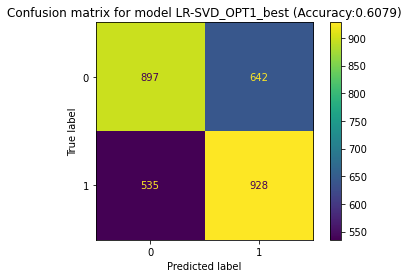

In [25]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt1 = best_model.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR-SVD_OPT1_best', y_test, predictions_opt1)])

In [26]:
study.best_params

{'penalty': 'l2', 'C': 1.978696921972353, 'max_iter': 354, 'solver': 'saga'}

In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
optuna.visualization.plot_parallel_coordinate(study)

In [29]:
optuna.visualization.plot_slice(study, params=['penalty', 'C', 'max_iter', 'solver'])

In [30]:
optuna.visualization.plot_param_importances(study)

In [31]:
optuna.visualization.plot_edf(study)

Enlarge 'C' range and add elasticnet parameter (comes with l1_ratio)

In [32]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [33]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 20:01:03,622] A new study created in memory with name: no-name-015825a8-6552-473d-a0ac-2c6e814e74fe
[I 2024-06-09 20:01:03,670] Trial 0 finished with value: 0.6079280479680214 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.6079280479680214.
[I 2024-06-09 20:01:03,709] Trial 1 finished with value: 0.6052631578947368 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 0.07659165484895042, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.6079280479680214.
[I 2024-06-09 20:01:03,742] Trial 2 finished with value: 0.6079280479680214 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 0.37133840345513924, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.6079280479680214.
[I 2024-06-09 20:01:03,773] Trial 3 finished with value: 0.5709526982011992 and parameters: {'l1_ratio': 0.

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.6079280479680214


In [34]:
# Get best trials
trials_OTP2 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP2 = trials_OTP2.sort_values(by='value', ascending=False).head(10)
top_trials_OTP2

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.607928,2024-06-09 20:01:03.624537,2024-06-09 20:01:03.669530,0 days 00:00:00.044993,61.355064,0.517298,789,elasticnet,saga,COMPLETE
71,71,0.607928,2024-06-09 20:01:06.137469,2024-06-09 20:01:06.165504,0 days 00:00:00.028035,0.453414,0.313701,455,elasticnet,saga,COMPLETE
145,145,0.607928,2024-06-09 20:01:08.685425,2024-06-09 20:01:08.712424,0 days 00:00:00.026999,33.970558,0.457046,429,elasticnet,saga,COMPLETE
150,150,0.607928,2024-06-09 20:01:08.832390,2024-06-09 20:01:08.869397,0 days 00:00:00.037007,0.490034,0.193003,825,elasticnet,saga,COMPLETE
84,84,0.607928,2024-06-09 20:01:06.676448,2024-06-09 20:01:06.709477,0 days 00:00:00.033029,12.369230,0.188790,631,elasticnet,saga,COMPLETE
83,83,0.607928,2024-06-09 20:01:06.643443,2024-06-09 20:01:06.675480,0 days 00:00:00.032037,2.561741,0.638415,176,elasticnet,saga,COMPLETE
151,151,0.607928,2024-06-09 20:01:08.872433,2024-06-09 20:01:08.909433,0 days 00:00:00.037000,54.003560,0.857694,548,elasticnet,saga,COMPLETE
80,80,0.607928,2024-06-09 20:01:06.559481,2024-06-09 20:01:06.587480,0 days 00:00:00.027999,17.773542,0.772604,527,elasticnet,saga,COMPLETE
78,78,0.607928,2024-06-09 20:01:06.499453,2024-06-09 20:01:06.529482,0 days 00:00:00.030029,36.584782,0.394012,127,elasticnet,saga,COMPLETE
76,76,0.607928,2024-06-09 20:01:06.420459,2024-06-09 20:01:06.460448,0 days 00:00:00.039989,1.696042,0.093178,980,elasticnet,saga,COMPLETE


Metrics for LR-SVD_OPT2_best:
Accuracy: 0.6079
Weighted F1: 0.6078
Weighted Precision: 0.6092
Weighted Recall: 0.6079
Macro-Averaged Precision: 0.6087
Macro-Averaged Recall: 0.6086
F1: [0.60383709 0.61193538]
Precision: [0.62639665 0.5910828 ]
classification report
              precision    recall  f1-score   support

     Class 0       0.63      0.58      0.60      1539
     Class 1       0.59      0.63      0.61      1463

    accuracy                           0.61      3002
   macro avg       0.61      0.61      0.61      3002
weighted avg       0.61      0.61      0.61      3002

Confusion Matrix


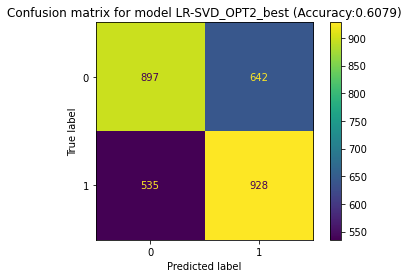

In [35]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt2 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR-SVD_OPT2_best', y_test, predictions_opt2)])

In [36]:
optuna.visualization.plot_param_importances(study)

Make 'C' interval uniform (as it remains the most important hyperparameter)

In [37]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_uniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [38]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 20:01:12,015] A new study created in memory with name: no-name-f840efad-c935-4380-be51-3c203bc8f0aa
[I 2024-06-09 20:01:12,055] Trial 0 finished with value: 0.6079280479680214 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.6079280479680214.
[I 2024-06-09 20:01:12,095] Trial 1 finished with value: 0.6079280479680214 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 22.112325872532644, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.6079280479680214.
[I 2024-06-09 20:01:12,144] Trial 2 finished with value: 0.6079280479680214 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 39.25032222183841, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.6079280479680214.
[I 2024-06-09 20:01:12,186] Trial 3 finished with value: 0.6069287141905396 and parameters: {'l1_ratio': 0.411

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.6079280479680214


In [39]:
# Get best trials
trials_OTP3 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP3 = trials_OTP3.sort_values(by='value', ascending=False).head(10)
top_trials_OTP3

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.607928,2024-06-09 20:01:12.018305,2024-06-09 20:01:12.054309,0 days 00:00:00.036004,94.696791,0.517298,789,elasticnet,saga,COMPLETE
125,125,0.607928,2024-06-09 20:01:16.855381,2024-06-09 20:01:16.884363,0 days 00:00:00.028982,46.342253,0.169274,111,elasticnet,saga,COMPLETE
127,127,0.607928,2024-06-09 20:01:16.917365,2024-06-09 20:01:16.947401,0 days 00:00:00.030036,26.262630,0.535513,567,elasticnet,saga,COMPLETE
128,128,0.607928,2024-06-09 20:01:16.948396,2024-06-09 20:01:16.981362,0 days 00:00:00.032966,29.230015,0.477792,465,elasticnet,saga,COMPLETE
129,129,0.607928,2024-06-09 20:01:16.982362,2024-06-09 20:01:17.011360,0 days 00:00:00.028998,43.747745,0.474294,114,elasticnet,saga,COMPLETE
130,130,0.607928,2024-06-09 20:01:17.012362,2024-06-09 20:01:17.044395,0 days 00:00:00.032033,75.930643,0.705562,345,elasticnet,saga,COMPLETE
131,131,0.607928,2024-06-09 20:01:17.045397,2024-06-09 20:01:17.103373,0 days 00:00:00.057976,72.450796,0.465636,174,elasticnet,saga,COMPLETE
132,132,0.607928,2024-06-09 20:01:17.106360,2024-06-09 20:01:17.155358,0 days 00:00:00.048998,72.067713,0.849127,992,elasticnet,saga,COMPLETE
133,133,0.607928,2024-06-09 20:01:17.157369,2024-06-09 20:01:17.193356,0 days 00:00:00.035987,25.327685,0.445845,244,elasticnet,saga,COMPLETE
134,134,0.607928,2024-06-09 20:01:17.194356,2024-06-09 20:01:17.229356,0 days 00:00:00.035000,68.777096,0.870727,442,elasticnet,saga,COMPLETE


Metrics for LR-SVD_OPT3_best:
Accuracy: 0.6079
Weighted F1: 0.6078
Weighted Precision: 0.6092
Weighted Recall: 0.6079
Macro-Averaged Precision: 0.6087
Macro-Averaged Recall: 0.6086
F1: [0.60383709 0.61193538]
Precision: [0.62639665 0.5910828 ]
classification report
              precision    recall  f1-score   support

     Class 0       0.63      0.58      0.60      1539
     Class 1       0.59      0.63      0.61      1463

    accuracy                           0.61      3002
   macro avg       0.61      0.61      0.61      3002
weighted avg       0.61      0.61      0.61      3002

Confusion Matrix


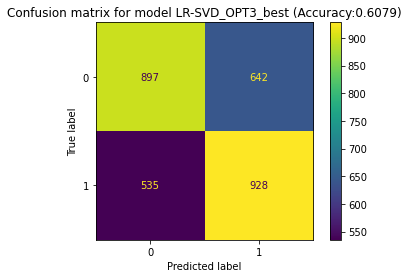

In [40]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt3 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR-SVD_OPT3_best', y_test, predictions_opt3)])

end

In [41]:
model_metrics

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
LR-SVD-untuned,0.607928,0.607784,0.609187,0.607928,0.60874,0.60858,[0.60383709 0.61193538],[0.62639665 0.5910828 ]
LR-SVD_CV1_best,0.607928,0.607784,0.609187,0.607928,0.60874,0.60858,[0.60383709 0.61193538],[0.62639665 0.5910828 ]
LR-SVD_skf_best,0.607928,0.607784,0.609187,0.607928,0.60874,0.60858,[0.60383709 0.61193538],[0.62639665 0.5910828 ]
LR-SVD_OPT1_best,0.607928,0.607784,0.609187,0.607928,0.60874,0.60858,[0.60383709 0.61193538],[0.62639665 0.5910828 ]
LR-SVD_OPT2_best,0.607928,0.607784,0.609187,0.607928,0.60874,0.60858,[0.60383709 0.61193538],[0.62639665 0.5910828 ]
LR-SVD_OPT3_best,0.607928,0.607784,0.609187,0.607928,0.60874,0.60858,[0.60383709 0.61193538],[0.62639665 0.5910828 ]
